In [2]:
import numpy as np
import pandas as pd
import json
!pip install ase
#from dscribe.descriptors import CoulombMatrix
from ase import Atoms
import matplotlib.pyplot as plt
import matplotlib
font = {'size'   : 22}

In [6]:
##

## Importing data from google drive


In [7]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
data_dir = '/project/db/'
# Loading the data as pandas DataFrame
train = pd.DataFrame(json.load(open(data_dir + "train.json", "rb")))
test = pd.DataFrame(json.load(open(data_dir + "test.json", "rb")))
## Transform atoms entry to ASE atoms object
train.atoms = train.atoms.apply(lambda x: Atoms(**x)) # OBS This one is important!
test.atoms = test.atoms.apply(lambda x: Atoms(**x))

In [9]:
train.head()

,formula,etot,dynamic_stability_level,atoms,Voigt_modulus
0,W2S2,-31.329664,1,"(Atom('W', [1.52711328, 0.8816792633, 9.115147...",80.175958
1,NiI2,-9.774512,2,"(Atom('Ni', [-7.814021732e-19, -1.673235808e-1...",31.358817
2,Ti3F2N2,-55.546656,1,"(Atom('Ti', [0.0, 0.0, 11.208358341], index=0)...",155.068663
3,Hf4N3O2,-85.216280,3,"(Atom('Hf', [0.0, 1.8605461437, 11.1322923235]...",279.073400
4,NbSTe,-19.876790,1,"(Atom('Nb', [1.26844161e-17, -3.001405002e-18,...",55.639070


In [10]:
train.atoms[0]

Atoms(symbols='W2S2', pbc=[True, True, False], cell=[[3.0542265601, -1.170362187e-19, 0.0], [-1.52711328, 2.64503779, 0.0], [1.403752875e-20, 0.0, 20.8432900495]])

In [4]:
def pad_with(vector, pad_width, iaxis, kwargs):
     pad_value = kwargs.get('padder', 10)
     vector[:pad_width[0]] = pad_value
     vector[-pad_width[1]:] = pad_value


def coulomb_matrix(atoms, n_atoms_max):
    # Creating a matrix with the product of the atomic numbers such that M_ij = Z[i]*Z[j]
    atomic_numbers = np.outer(atoms.get_atomic_numbers(),atoms.get_atomic_numbers())
    # Getting the distance matrix of the atoms object, such that element D_ij = |r_i - r_j|
    distances = atoms.get_all_distances()
    # Setting the diagonal elements, which are all zero, to 1 to avoid overflow errors
    np.fill_diagonal(distances, 1)
    
    # Creating the Cmat
    cmat = np.multiply(atomic_numbers, 1/distances) # Element wise multiplication
    np.fill_diagonal(cmat, 0.5*np.array(atoms.get_atomic_numbers())**2.4) # Filling the diagonal as described in the slides
    
    # Taking the sorted eigenvalues and padding with zeros such that all of the fingerprints have the same size
    shape = cmat.shape
    cmat,_ = np.linalg.eig(cmat)
    cmat = np.flip(np.sort(cmat))
    holder = np.zeros(n_atoms_max)
    holder[:shape[0]] = cmat
    cmat = holder
    
    return cmat

In [5]:
species = []
number_of_atoms = []
atomic_numbers = []
for atom in pd.concat([train.atoms,test.atoms]):
    species = list(set(species+atom.get_chemical_symbols()))
    atomic_numbers = list(set(atomic_numbers+list(atom.get_atomic_numbers())))
    number_of_atoms.append(atom.get_number_of_atoms())

max_number_of_atoms = np.max(number_of_atoms)
min_atomic_number = np.min(atomic_numbers)

print(max_number_of_atoms)

12


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ase/atoms.py:971: VisibleDeprecationWarning: Use get_global_number_of_atoms() instead
  warnings.warn('Use get_global_number_of_atoms() instead',


In [6]:
cmats = np.zeros((len(train),max_number_of_atoms))
for i,atoms in enumerate(train.atoms):
    if i%1000 == 0:
        print(i)
    cmat = coulomb_matrix(atoms,max_number_of_atoms)
    cmats[i,:] = cmat.flatten()
print(len(cmats))

0
1000
2000
2028


In [7]:
X = pd.DataFrame(data = cmats, index=train.index)
y = train['Voigt_modulus']
print('X: {}'.format(X.shape))
print('y: {}'.format(y.shape))

X: (2028, 12)
y: (2028,)


In [8]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

# Instantiate a Gaussian Process model
kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)

# Fit to data using Maximum Likelihood Estimation of the parameters
gp.fit(X, y)

# Make the prediction on the meshed x-axis (ask for MSE as well)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:509: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


GaussianProcessRegressor(kernel=1**2 * RBF(length_scale=10),
                         n_restarts_optimizer=9)

In [9]:
gp.get_params()

{'alpha': 1e-10,
 'copy_X_train': True,
 'kernel__k1': 1**2,
 'kernel__k2': RBF(length_scale=10),
 'kernel__k1__constant_value': 1.0,
 'kernel__k1__constant_value_bounds': (0.001, 1000.0),
 'kernel__k2__length_scale': 10,
 'kernel__k2__length_scale_bounds': (0.01, 100.0),
 'kernel': 1**2 * RBF(length_scale=10),
 'n_restarts_optimizer': 9,
 'normalize_y': False,
 'optimizer': 'fmin_l_bfgs_b',
 'random_state': None}

In [10]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import StandardScaler

def rmse(y_true, y_pred):
    return np.sqrt(mse(y_true, y_pred))

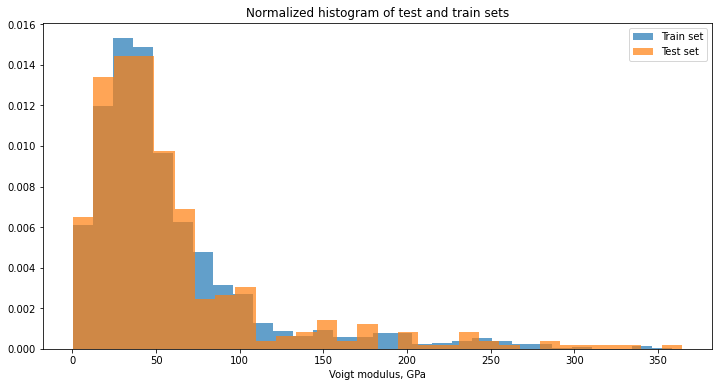

In [11]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=250)

plt.figure(figsize = (12, 6))
plt.hist(y_train, bins=30, alpha=0.7, density=True, label='Train set')
plt.hist(y_test, bins=30, alpha=0.7, density=True, label='Test set')

plt.title("Normalized histogram of test and train sets")
plt.xlabel("Voigt modulus, GPa")
plt.legend()
plt.show()

In [12]:
print(X_train)

                0             1            2            3            4   \
951   19986.308055  17014.441118   490.814141   347.960775   334.507228   
1357   1473.457186    905.697035   341.199042   320.630069     0.000000   
232    7781.725144   6373.178436  3356.557732  2822.242023     0.000000   
1568   4647.985244   3257.617709    97.857082    57.632492    55.373688   
1723   7751.564395   6095.062416  1656.214407     0.000000     0.000000   
...            ...           ...          ...          ...          ...   
1015   4657.735210     79.493681    51.536236     0.000000     0.000000   
1760   9663.022554   6180.212697  6116.367843  6108.742080  5764.973367   
218   16814.649374  12882.711658   413.696606   311.587230     0.000000   
589   19598.251736     69.271561     0.000000     0.000000     0.000000   
1902  19785.373173  16106.811638   466.607964   398.212968    71.176727   

               5           6           7           8           9    10   11  
951    311.180038    

In [13]:
test_prediction = gp.predict(X_test)
train_prediction = gp.predict(X_train)


In [14]:
print('Train RMSE = {:.2f}'.format(rmse(y_train,train_prediction)))
print('Test RMSE = {:.2f}'.format(rmse(y_test,test_prediction)))

Train RMSE = 0.08
Test RMSE = 0.10


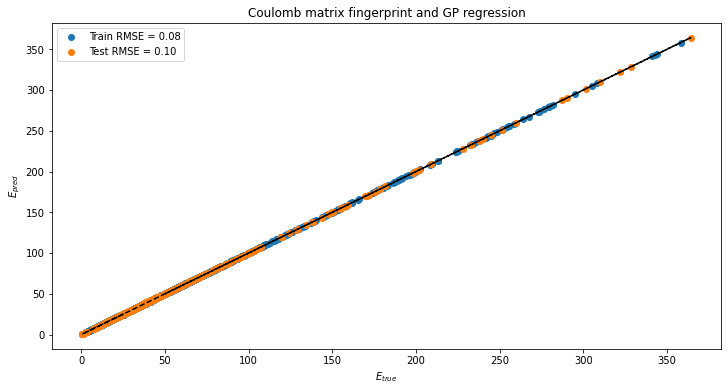

In [15]:
fig = plt.figure(figsize = (12, 6))

plt.title("Coulomb matrix fingerprint and GP regression")
plt.scatter(y_train, gp.predict(X_train), label = 'Train RMSE = {:.2f}'.format(rmse(y_train,train_prediction)))
plt.scatter(y_test, gp.predict(X_test), label = 'Test RMSE = {:.2f}'.format(rmse(y_test,test_prediction)))
plt.plot(y_test, y_test, linestyle = "--", color = "k")
plt.xlabel("$E_{true}$")
plt.ylabel("$E_{pred}$")
plt.legend()
plt.show()  